In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import eli5
import shap
from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
from lib.training import *

In [3]:
data_name = '1408'
with pd.HDFStore('./hdf/LearningSets.h5',complib='blosc:blosclz') as store:
    data = store[f'{data_name}/data']
    categorial_features = list(store[f'{data_name}/categorial_features'].values.flatten())
    numerical_features = list(store[f'{data_name}/numerical_features'].values.flatten())

In [14]:
X = data[data['isFraud'] >= 0].drop(['isFraud','Date'],axis=1)
y = data[data['isFraud'] >= 0]['isFraud'].astype(np.bool)
X_test = data[data['isFraud'] < 0].drop(['isFraud','Date'],axis=1)   

In [8]:
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)
# folds = GroupKFold(n_splits=5)
# groups = pd.read_pickle('./groups.pkl').values

In [9]:
categorical_columns = [c for c, col in enumerate(X.columns) if col in categorial_features]

In [10]:
categorical_columns


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 299,
 300,
 301,
 302,
 303,
 306,
 307,
 308,
 309]

Fold 1 started at Wed Aug 14 21:23:49 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999598	training's auc: 0.999598	valid_1's auc: 0.909531	valid_1's auc: 0.909531
[1000]	training's auc: 1	training's auc: 1	valid_1's auc: 0.911287	valid_1's auc: 0.911287
Early stopping, best iteration is:
[1267]	training's auc: 1	training's auc: 1	valid_1's auc: 0.91241	valid_1's auc: 0.91241
Fold 2 started at Wed Aug 14 21:35:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[205]	training's auc: 0.993682	training's auc: 0.993682	valid_1's auc: 0.933639	valid_1's auc: 0.933639
Fold 3 started at Wed Aug 14 21:38:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[182]	training's auc: 0.992266	training's auc: 0.992266	valid_1's auc: 0.930865	valid_1's auc: 0.930865
Fold 4 started at Wed Aug 14 21:41:51 2019
Training until validation scores don't imp

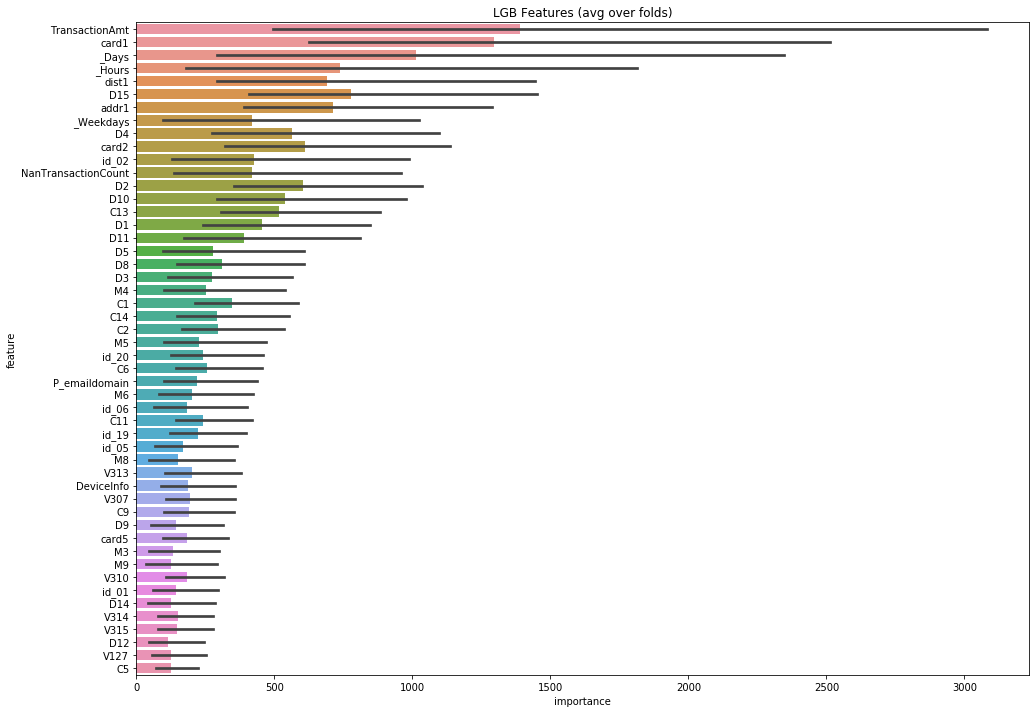

In [17]:
params = {'num_leaves': 300,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'categorical_feature': categorical_columns,
#           'device': 'gpu'
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1, groups=None)

In [17]:
# cat_params = {'num_leaves': 256,
#           'min_child_samples': 79,
#           'objective': 'CrossEntropy',
#           'max_depth': 13,
#           'learning_rate': 0.03,
#           "boosting_type": "Ordered",
#           'reg_lambda': 0.3,
#           'task_type':'GPU'
#          }
# result_dict_cat = train_model_classification(X=X, X_test=X_test, y=y, params=cat_params, folds=folds, model_type='cat', eval_metric='auc', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [18]:
test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [19]:
result_dict_lgb['prediction']


array([[0.00016328],
       [0.00085254],
       [0.00030675],
       ...,
       [0.00320967],
       [0.00153367],
       [0.00099229]])

In [20]:
test.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,card_id,TransactionAmt_to_mean_card_id,TransactionAmt_to_std_card_id,dist1_to_mean_card_id,dist1_to_std_card_id,dist2_to_mean_card_id,dist2_to_std_card_id,_Hours_to_mean_card_id,_Hours_to_std_card_id,prediction
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,31.953125,4,442,11,50,3,126,2,70,80,...,844,0.28662109375,0.251708984375,0.008880615234375,0.005661010742188,NaN,NaN,0.0,0.0,0.000163281022142
3663550,49.000000,4,11471,11,50,3,126,2,199,80,...,86,0.31933593750,0.000000000000,0.035461425781250,0.000000000000000,NaN,NaN,0.0,0.0,0.000852535644590
3663551,171.000000,4,11668,474,50,3,126,2,372,80,...,1403,1.23339843750,1.261718750000,2.183593750000000,0.000000000000000,NaN,NaN,0.0,0.0,0.000306745314989
3663552,285.000000,4,1069,260,50,3,66,2,105,80,...,93,3.17382812500,2.183593750000,0.187744140625000,0.000000000000000,NaN,NaN,0.0,0.0,0.000102925418759
3663553,67.937500,4,8674,352,50,2,17,2,164,80,...,64,0.58740234375,0.316650390625,0.062225341796875,0.000000000000000,NaN,NaN,0.0,0.0,0.000189674552193


In [21]:
folder_path = './data/'
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
sub.to_csv('submission_7_filter_kfold.csv', index=False)